In [1]:
import requests
import pandas as pd
import os
import time
from datetime import datetime

# Function to download a file with retry logic
def download_file(url, destination):
    retries = 3
    while retries > 0:
        try:
            response = requests.get(url)
            with open(destination, 'wb') as f:
                f.write(response.content)
            print(f"Downloaded {url} to {destination}")
            return True
        except requests.exceptions.RequestException as e:
            print(f"Error downloading {url}: {e}")
            retries -= 1
            if retries > 0:
                print(f"Retrying {retries} more times...")
                time.sleep(5)  # Wait for 5 seconds before retrying
    return False

# Function to convert a Parquet file to CSV
def parquet_to_csv(parquet_file, csv_file):
    try:
        df = pd.read_parquet(parquet_file)
        df.to_csv(csv_file, index=False)
        print(f"Converted {parquet_file} to {csv_file}")
        return True
    except Exception as e:
        print(f"Error converting {parquet_file} to CSV: {e}")
        return False

# Base URL for Parquet files (replace with actual URL)
base_url = 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_'

# List of month names
months = ['01']

# Year for which data is to be downloaded
year = '2019'

# Iterate over each month
for month in months:
    parquet_url = f"{base_url}{year}-{month}.parquet"
    parquet_file = f"{year}-{month}.parquet"
    csv_file = f"{year}-{month}.csv"

    # Download the Parquet file
    if download_file(parquet_url, parquet_file):
        # Convert the Parquet file to CSV
        if parquet_to_csv(parquet_file, csv_file):
            # Clean up the downloaded Parquet file if needed
            os.remove(parquet_file)
        else:
            print(f"Conversion failed for {parquet_file}. Keeping the Parquet file.")
    else:
        print(f"Download failed for {parquet_url}. Conversion aborted.")
    
    print()  # Print a blank line for better readability between months

Error downloading https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2019-01.parquet: HTTPSConnectionPool(host='d37ci6vzurychx.cloudfront.net', port=443): Max retries exceeded with url: /trip-data/yellow_tripdata_2019-01.parquet (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000023E89210D40>: Failed to resolve 'd37ci6vzurychx.cloudfront.net' ([Errno 11001] getaddrinfo failed)"))
Retrying 2 more times...
Error downloading https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2019-01.parquet: HTTPSConnectionPool(host='d37ci6vzurychx.cloudfront.net', port=443): Max retries exceeded with url: /trip-data/yellow_tripdata_2019-01.parquet (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000023E8D2078F0>: Failed to resolve 'd37ci6vzurychx.cloudfront.net' ([Errno 11001] getaddrinfo failed)"))
Retrying 1 more times...
Error downloading https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2019-01.pa

In [2]:
import pandas as pd
import numpy as np

# Path to your CSV file
csv_file = '2019-01.csv'

# Read the CSV file into a pandas DataFrame
try:
    taxi_data = pd.read_csv(csv_file)
    # Print the first few rows of the DataFrame to verify it was read correctly
    #print(taxi_data.head())
except FileNotFoundError:
    print(f"Error: The file '{csv_file}' was not found.")
except pd.errors.EmptyDataError:
    print(f"Error: The file '{csv_file}' is empty or not properly formatted.")
except Exception as e:
    print(f"Error reading '{csv_file}': {e}")

#print(taxi_data)
# Cleaning data: Remove trips with missing or corrupt data
#taxi_data.dropna(inplace=True)
#print(taxi_data)
# Convert pickup and drop-off time to datetime objects
taxi_data['tpep_pickup_datetime'] = pd.to_datetime(taxi_data['tpep_pickup_datetime'])
taxi_data['tpep_dropoff_datetime'] = pd.to_datetime(taxi_data['tpep_dropoff_datetime'])

# Derive new columns: trip duration and average speed
taxi_data['trip_duration'] = (taxi_data['tpep_dropoff_datetime'] - taxi_data['tpep_pickup_datetime']).dt.total_seconds() / 60  # in minutes
taxi_data['average_speed'] = taxi_data['trip_distance'] / (taxi_data['trip_duration'] / 60)  # miles per hour

#print(taxi_data)
# Aggregate data: Calculate total trips and average fare per day
taxi_data['pickup_date'] = taxi_data['tpep_pickup_datetime'].dt.date
#print(taxi_data)
daily_metrics = taxi_data.groupby('pickup_date').agg(
    total_trips=('tpep_pickup_datetime', 'count'),
    average_fare=('total_amount', 'mean')
).reset_index()

print(daily_metrics)

daily_metrics.to_csv('csv_data.csv', header=True)


   pickup_date  total_trips  average_fare
0   2001-02-02            1      3.800000
1   2003-01-01            2      0.000000
2   2008-12-31           22     14.134545
3   2009-01-01           50     14.738400
4   2018-11-28           10     77.324000
5   2018-11-29            1     14.550000
6   2018-12-21            1      5.800000
7   2018-12-30            9     16.746667
8   2018-12-31          345     17.776348
9   2019-01-01       189432     16.951245
10  2019-01-02       198737     16.866435
11  2019-01-03       223965     15.976209
12  2019-01-04       236089     15.669991
13  2019-01-05       236506     14.296231
14  2019-01-06       208823     15.539447
15  2019-01-07       228816     15.922282
16  2019-01-08       237310     15.743497
17  2019-01-09       255868     15.720588
18  2019-01-10       281863     15.833929
19  2019-01-11       291714     18.000320
20  2019-01-12       265115     14.671119
21  2019-01-13       227502     15.302722
22  2019-01-14       245082     16

In [3]:
import sqlite3
import pandas as pd

# Connect to SQLite database
conn = sqlite3.connect('taxi_data.db')
cursor = conn.cursor()

# Create trips table if not exists
cursor.execute('''
    CREATE TABLE IF NOT EXISTS taxi_trips (
         VendorID               INTEGER,
         tpep_pickup_datetime   DATETIME,
         tpep_dropoff_datetime  DATETIME,
         passenger_count        REAL       ,
         trip_distance          REAL       ,
         RatecodeID             REAL       ,
         store_and_fwd_flag     string        ,
         PULocationID           INTEGER         ,
         DOLocationID           INTEGER         ,
         payment_type           INTEGER         ,
         fare_amount            REAL       ,
         extra                  REAL       ,
         mta_tax                REAL       ,
         tip_amount             REAL       ,
         tolls_amount           REAL       ,
         improvement_surcharge  REAL       ,
         total_amount           REAL       ,
         congestion_surcharge   REAL       ,
         airport_fee            REAL       ,
         trip_duration          REAL       ,
         average_speed          REAL       ,
         pickup_date            string  

    )
''')

# Create trip metrics table if not exists
cursor.execute('''
    CREATE TABLE IF NOT EXISTS trip_metrics (
        pickup_date DATE PRIMARY KEY,
        total_trips INTEGER,
        average_fare REAL
    )
''')

# Insert data into the trips table
taxi_data.to_sql('taxi_trips', conn, if_exists='replace', index=False)

# Close the SQLite connection
conn.close()


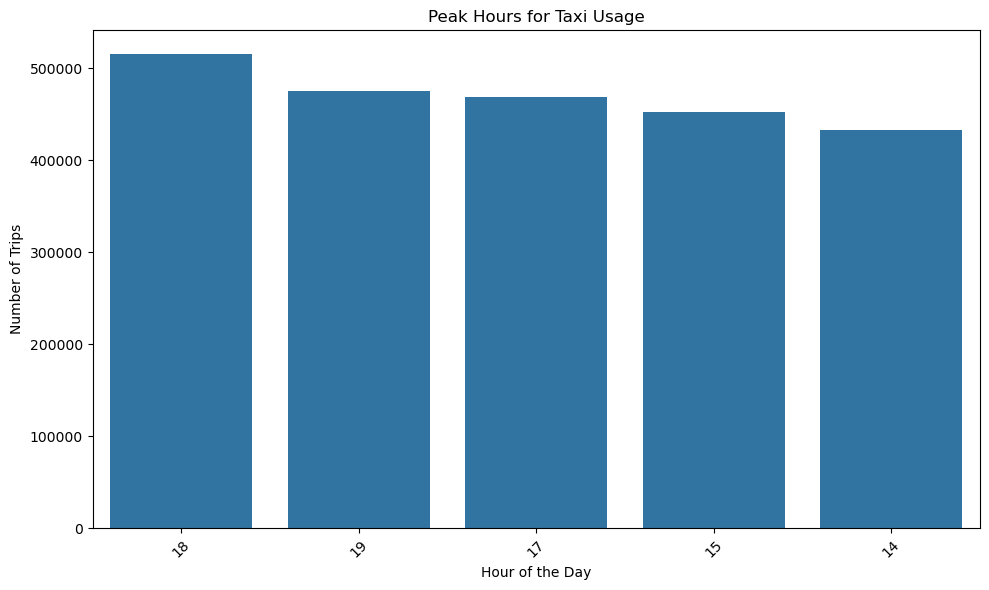

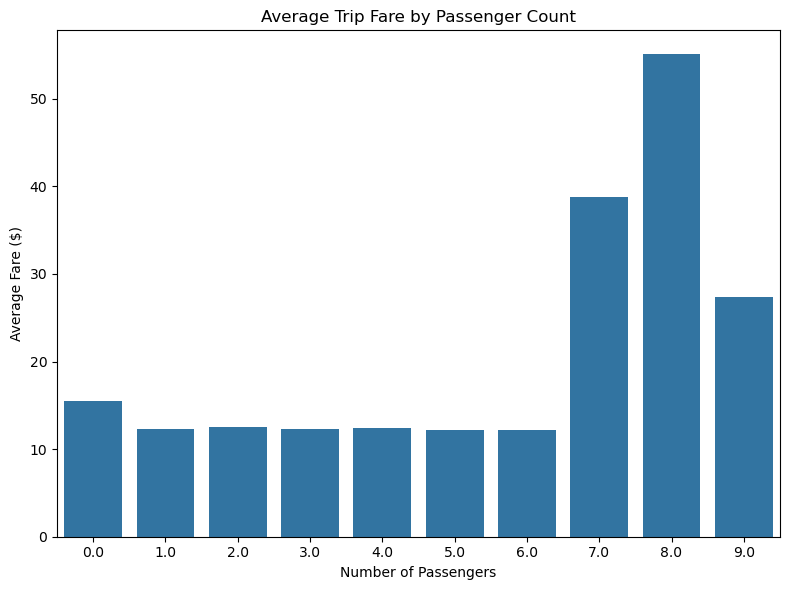

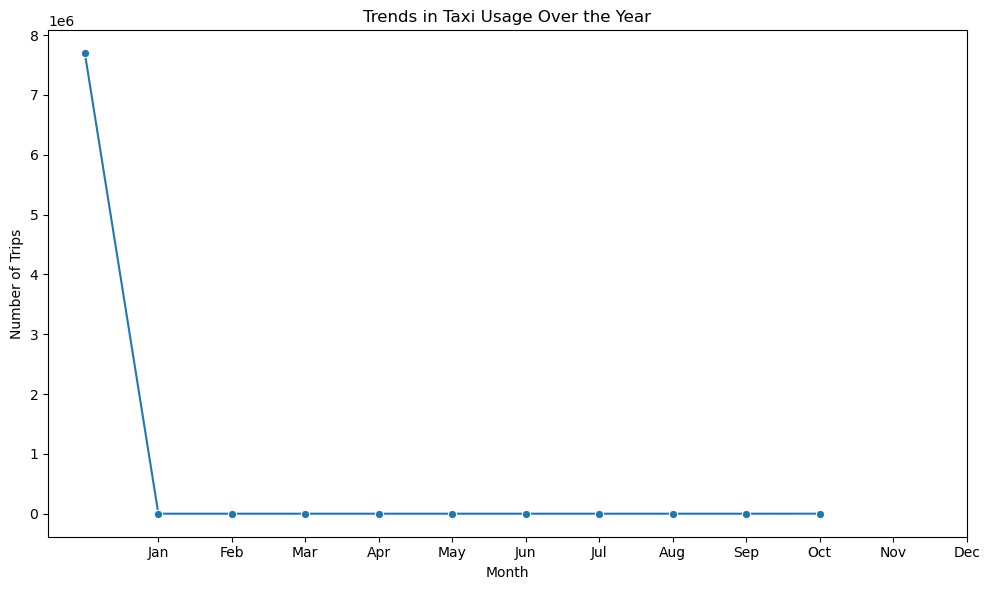

In [4]:

# Reconnect to SQLite database
conn = sqlite3.connect('taxi_data.db')

# Example SQL queries to answer the questions

# 1. Peak hours for taxi usage
peak_hours_query = '''
    SELECT strftime('%H', tpep_pickup_datetime) AS hour_of_day, COUNT(*) AS trips_count
    FROM taxi_trips
    GROUP BY hour_of_day
    ORDER BY trips_count DESC
    LIMIT 5;
'''

# Execute the query and load results into a DataFrame
peak_hours_df = pd.read_sql_query(peak_hours_query, conn)

# Plotting peak hours
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x='hour_of_day', y='trips_count', data=peak_hours_df)
plt.title('Peak Hours for Taxi Usage')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Trips')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. How does passenger count affect trip fare?
passenger_count_query = '''
    SELECT passenger_count, AVG(fare_amount) AS avg_fare
    FROM taxi_trips
    GROUP BY passenger_count
    ORDER BY passenger_count;
'''

# Execute the query and load results into a DataFrame
passenger_count_df = pd.read_sql_query(passenger_count_query, conn)

# Plotting passenger count vs trip fare
plt.figure(figsize=(8, 6))
sns.barplot(x='passenger_count', y='avg_fare', data=passenger_count_df)
plt.title('Average Trip Fare by Passenger Count')
plt.xlabel('Number of Passengers')
plt.ylabel('Average Fare ($)')
plt.tight_layout()
plt.show()

# 3. Trends in usage over the year
usage_trends_query = '''
    SELECT strftime('%m', tpep_pickup_datetime) AS month, COUNT(*) AS trips_count
    FROM taxi_trips
    GROUP BY month
    ORDER BY month;
'''

# Execute the query and load results into a DataFrame
usage_trends_df = pd.read_sql_query(usage_trends_query, conn)

# Plotting trends in usage over the year
plt.figure(figsize=(10, 6))
sns.lineplot(x='month', y='trips_count', data=usage_trends_df, marker='o')
plt.title('Trends in Taxi Usage Over the Year')
plt.xlabel('Month')
plt.ylabel('Number of Trips')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.tight_layout()
plt.show()

# Close the SQLite connection
conn.close()
